In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
from prettytable import PrettyTable
from scipy import sparse
import csv

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
pt = PrettyTable()
pt.field_names = ["Model", "Optimal Parameters", "Scoring Metric", "Score", "TPR", "TNR", "FPR", "FNR"]

In [3]:
def standardize_data(train, train_vectors, test, test_vectors):
    sc = StandardScaler()
    
    y_train = train['Score']
    X_train = train.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)
    X_train = sc.fit_transform(X_train)
    print(X_train.shape, train_vectors.shape)
    X_train = np.hstack((X_train, train_vectors))
    
    print('X_Train: {0}'.format(X_train.shape))
    print('y_Train: {0}'.format(y_train.shape))
    
    y_test = test['Score']
    X_test = test.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)
    X_test = sc.transform(X_test)
    X_test = np.hstack((X_test, test_vectors))
    
    print('X_Test: {0}'.format(X_test.shape))
    print('y_Test: {0}'.format(y_test.shape))
    
    return X_train, y_train, X_test, y_test

In [4]:
def plot_scores(optimal_model):
    _, = plt.plot(list(optimal_model.cv_results_['param_C']), \
                      list(optimal_model.cv_results_['mean_train_score']), 'g-', \
                     label='Training Scores')
    _, = plt.plot(list(optimal_model.cv_results_['param_C']), \
                      list(optimal_model.cv_results_['mean_test_score']), 'r-', \
                      label='Test Scores')
    _, = plt.plot(optimal_model.best_params_['C'], optimal_model.best_score_, 'bo', \
                     label=f"Optimal Value (a={optimal_model.best_params_['C']}, Score={round(optimal_model.best_score_,2)})")

    plt.xscale('log')
    plt.xlabel('C-Values')
    plt.ylabel('Scores')
    plt.legend()
    plt.show()

In [9]:
def run_LR(train, train_vectors, test, test_vectors, metric='precision_macro'):
    '''
    Perform Logisitic Regression modelling on the I/P Train and Test data.
    1. Remove not required Columns, Standardize data and concatenate data with the text vectors.
    2. Perform Cross Validation and find Optimal parameters - 'penalty' & 'c'.
    3. Use the Optimal parameters based model on the Training data and evaluate the Test data.
    4. Calculate Accuracy of Model and TPR, TNR, FPR, FNR.
    '''
    # Drop not required Columns, Standardize data and concatenate data with text vectors
    X_train, y_train, X_test, y_test = standardize_data(train, train_vectors, test, test_vectors)

    del train, train_vectors, test, test_vectors

    lr = LogisticRegression(random_state=42, warm_start=True)
    parameters = {'penalty':('l1', 'l2'), 'C':(0.01, 0.1, 1.0, 10.0), 'solver':('liblinear',)}
    lr_optimal = GridSearchCV(lr, param_grid=parameters, cv=3, scoring=metric, verbose=0)
    lr_optimal.fit(X_train, y_train)

    # Plot Train vs Test Scores and the Optimal Parameter
    plot_scores(lr_optimal)

    # Confusion Matrix for Train Data
    pred = []
    for i in range(0, X_train.shape[0], 2000):
        test_batch = X_train[i:i+2000]
        pred.extend(lr_optimal.predict(test_batch))
    conf_matrix = confusion_matrix(y_train, pred)
    TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    print('\nConfusion Matrix for Train Data :-')
    print(conf_matrix)
    print("\nTPR: {0} %\nTNR: {1} %\nFPR: {2} %\nFNR: {3} %\n".format(TPR*100, TNR*100, FPR*100, FNR*100))
    
    del X_train, y_train
    
    # Confusion Matrix for Test Data
    pred = []
    for i in range(0, X_test.shape[0], 2000):
        test_batch = X_test[i:i+2000]
        pred.extend(lr_optimal.predict(test_batch))

    ps = precision_score(y_test, pred, average='macro') * 100
    print(f'\nPrecision_Score of the Optimal LR classifier with parameters-{lr_optimal.best_params_} is {ps} %')
    
    conf_matrix = confusion_matrix(y_test, pred)
    TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    print('\nConfusion Matrix for Test Data :-')
    print(conf_matrix)
    print("\nTPR: {0} %\nTNR: {1} %\nFPR: {2} %\nFNR: {3} %\n".format(TPR*100, TNR*100, FPR*100, FNR*100))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
    print('\nClassification Report :-\n')
    print(classification_report(y_test, pred))
    
    return [lr_optimal.best_params_, metric, round(ps,2), round(TPR*100,2), round(TNR*100,2), \
            round(FPR*100,2), round(FNR*100,2), lr_optimal.cv_results_, lr_optimal.best_estimator_.coef_[0]]

In [6]:
data_train = pd.read_csv('./Matrices/data_train.csv')
data_test = pd.read_csv('./Matrices/data_test.csv')

## Collinearity Test using VIF for BOW Vectorizer

In [6]:
data_train = pd.read_csv('./Matrices/sample2_data_train.csv')
data_test = pd.read_csv('./Matrices/sample2_data_test.csv')

In [7]:
%%time
cv_model = CountVectorizer(max_features=15000, min_df=5)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

(28000, 6857) (12000, 6857)
Wall time: 1.37 s


In [8]:
%%time
X_train, y_train, X_test, y_test = standardize_data(data_train, bow_counts_train.toarray(), \
                                                    data_test, bow_counts_test.toarray())

(28000, 4) (28000, 6857)
X_Train: (28000, 6861)
y_Train: (28000,)
X_Test: (12000, 6861)
y_Test: (12000,)
Wall time: 2.04 s


In [64]:
%%time
import statsmodels.api as sm
from operator import itemgetter

feat_names = feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + cv_model.get_feature_names()
vifs = []
for i in range(100):
    y = X_train[:,i]
    x = np.delete(X_train[:, :500], i, 1)
    rsq = sm.OLS(y, x).fit().rsquared
    vif = round(1/(1-rsq), 2)
    vifs.append((feat_names[i], vif))
vifs.sort(key=itemgetter(1), reverse=True)
print(vifs)

[('HelpfulnessDenominator', 22.15), ('HelpfulnessNumerator', 22.07), ('adam', 2.19), ('actor', 1.91), ('acid', 1.79), ('afterlif', 1.64), ('administr', 1.58), ('aerogarden', 1.56), ('TextLength', 1.49), ('abund', 1.35), ('acidophilus', 1.31), ('acerola', 1.26), ('abil', 1.24), ('add', 1.23), ('achiev', 1.2), ('ad', 1.19), ('abdomin', 1.18), ('abnorm', 1.18), ('accord', 1.18), ('activ', 1.18), ('accid', 1.17), ('advers', 1.17), ('addit', 1.16), ('affect', 1.16), ('affili', 1.16), ('acquir', 1.14), ('actual', 1.14), ('africa', 1.14), ('acn', 1.13), ('adhes', 1.13), ('abus', 1.12), ('adequ', 1.12), ('absorpt', 1.11), ('act', 1.11), ('adult', 1.11), ('aesthet', 1.11), ('accident', 1.1), ('action', 1.1), ('advoc', 1.1), ('abl', 1.09), ('accumul', 1.09), ('adher', 1.09), ('advantag', 1.09), ('advis', 1.09), ('aforement', 1.09), ('access', 1.08), ('accustom', 1.08), ('ach', 1.08), ('across', 1.08), ('adjust', 1.08), ('administ', 1.08), ('adopt', 1.08), ('adventur', 1.08), ('african', 1.08), (

### Conclusion :-
-  From the above results, only words 'HelpfulnessDenominator' and 'HelpfulnessNumerator' have very high collinearity, other features have values < 5%.

## Sparsity Comparison between 'L2' & 'L1' Regularized Models

In [10]:
%%time
lr = LogisticRegression(random_state=42, warm_start=True)
parameters = {'penalty':('l2',), 'C':(0.01, 0.1, 1.0, 10.0), 'solver':('liblinear',)}
lr_optimal = GridSearchCV(lr, param_grid=parameters, cv=3, scoring='precision_macro', verbose=1)
lr_optimal.fit(X_train, y_train)
l2_sparsity = lr_optimal.best_estimator_.coef_[0]

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   29.4s finished


Wall time: 30.9 s


In [34]:
# Check for Sparsity (# of 0's) in L2 based Model Weight Vector
print(f'L2 Regularizer based Model Weight Vector has {list(l2_sparsity).count(0)} zeros with Sparsity -> {list(l2_sparsity).count(0)/len(l2_sparsity)}')
print(f'Weight Vector with values between 0 and 1 -> {len(l2_sparsity[(l2_sparsity > 0) & (l2_sparsity < 1)])}')

L2 Regularizer based Model Weight Vector has 0 zeros with Sparsity -> 0.0
Weight Vector with values between 0 and 1 -> 4162


In [18]:
%%time
lr = LogisticRegression(random_state=42, warm_start=True)
parameters = {'penalty':('l1',), 'C':(0.01, 0.1, 1.0, 10.0), 'solver':('liblinear',)}
lr_optimal = GridSearchCV(lr, param_grid=parameters, cv=3, scoring='precision_macro', verbose=1)
lr_optimal.fit(X_train, y_train)
l1_sparsity = lr_optimal.best_estimator_.coef_[0]

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   25.3s finished


Wall time: 26.6 s


In [33]:
# Check for Sparsity (# of 0's) in L2 based Model Weight Vector
print(f'L1 Regularizer based Model Weight Vector has {list(l1_sparsity).count(0)} zeros with Sparsity -> {list(l1_sparsity).count(0)/len(l1_sparsity)}')
print(f'Weight Vector with values between 0 and 1 -> {len(l1_sparsity[(l1_sparsity > 0) & (l1_sparsity < 1)])}')

L1 Regularizer based Model Weight Vector has 6471 zeros with Sparsity -> 0.9431569742020114
Weight Vector with values between 0 and 1 -> 207


## Conclusion :-
- From the results obtained above, it is seen that 'L1' Regularizer based Models create a lot sparser Weight Vector than 'L2' Regularizer based Model.

## BOW Vectorizer based model

In [7]:
%%time
cv_model = CountVectorizer(max_features=15000, min_df=5)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

(56000, 9397) (24000, 9397)
Wall time: 2.91 s


(56000, 4) (56000, 9397)
X_Train: (56000, 9401)
y_Train: (56000,)
X_Test: (24000, 9401)
y_Test: (24000,)


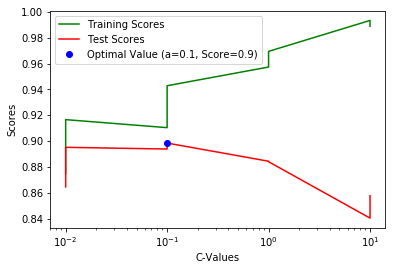


Confusion Matrix for Train Data :-
[[ 5798  1864]
 [  563 47775]]

TPR: 96.24488809202441 %
TNR: 91.14919037887125 %
FPR: 8.850809621128754 %
FNR: 3.7551119079755835 %


Precision_Score of the Optimal LR classifier with parameters-{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} is 90.02385326709651 %

Confusion Matrix for Test Data :-
[[ 2965  1134]
 [  500 19401]]

TPR: 94.47772096420745 %
TNR: 85.56998556998558 %
FPR: 14.43001443001443 %
FNR: 5.5222790357925495 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.86      0.72      0.78      4099
          1       0.94      0.97      0.96     19901

avg / total       0.93      0.93      0.93     24000

Wall time: 3min 30s


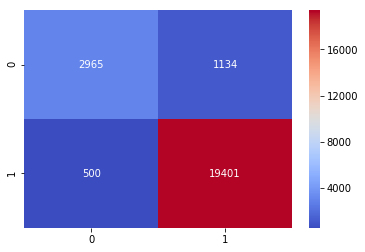

In [10]:
%%time
info = run_LR(data_train, bow_counts_train.toarray(), data_test, bow_counts_test.toarray())

In [11]:
%%time
n = 20; coeffs = info[-1]; coef_pt = PrettyTable();
coef_pt.field_names = ["Coeff_Neg", "Best Negative Features", "Coeff_Pos", "Best Positive Features"]
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + cv_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names))
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    coef_pt.add_row([round(coef_1,3), fn_1, round(coef_2,3), fn_2])
print(coef_pt)

+-----------+------------------------+-----------+------------------------+
| Coeff_Neg | Best Negative Features | Coeff_Pos | Best Positive Features |
+-----------+------------------------+-----------+------------------------+
|   -3.634  | HelpfulnessDenominator |   3.429   |  HelpfulnessNumerator  |
|   -1.754  |         worst          |   1.578   |         delici         |
|   -1.486  |       disappoint       |   1.489   |         excel          |
|   -1.426  |        horribl         |    1.3    |          best          |
|   -1.367  |        unfortun        |    1.28   |        perfect         |
|   -1.358  |           aw           |   1.201   |         awesom         |
|   -1.296  |        terribl         |   1.157   |         great          |
|   -1.077  |          poor          |   1.155   |         addict         |
|   -1.017  |        disgust         |   1.119   |          amaz          |
|   -0.986  |         bland          |   1.115   |         yummi          |
|   -0.971  

In [12]:
%%time
pt.add_row(['BOW'] + info[:-2])
print(pt)

+-------+----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
| Model |                 Optimal Parameters                 |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  | FNR  |
+-------+----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
|  BOW  | {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} | precision_macro | 90.02 | 94.48 | 85.57 | 14.43 | 5.52 |
+-------+----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
Wall time: 1 ms


In [13]:
del cv_model, bow_counts_train, bow_counts_test

## TFIDF Vectorizer based model

In [14]:
%%time
tfidf_model = TfidfVectorizer(max_features=15000, min_df=5)
tfidf_train = tfidf_model.fit_transform(data_train['CleanedText'].values)
tfidf_test = tfidf_model.transform(data_test['CleanedText'].values)
print(tfidf_train.shape, tfidf_test.shape)

(56000, 9397) (24000, 9397)
Wall time: 5.53 s


(56000, 4) (56000, 9397)
X_Train: (56000, 9401)
y_Train: (56000,)
X_Test: (24000, 9401)
y_Test: (24000,)


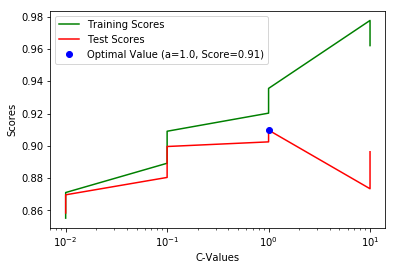


Confusion Matrix for Train Data :-
[[ 5406  2256]
 [  530 47808]]

TPR: 95.49376797698945 %
TNR: 91.07142857142857 %
FPR: 8.928571428571429 %
FNR: 4.506232023010546 %


Precision_Score of the Optimal LR classifier with parameters-{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'} is 91.3064773861137 %

Confusion Matrix for Test Data :-
[[ 2812  1287]
 [  355 19546]]

TPR: 93.82230115681851 %
TNR: 88.7906536154089 %
FPR: 11.209346384591095 %
FNR: 6.177698843181491 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.89      0.69      0.77      4099
          1       0.94      0.98      0.96     19901

avg / total       0.93      0.93      0.93     24000

Wall time: 2min 35s


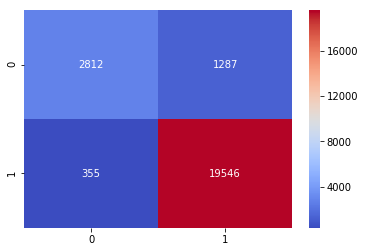

In [15]:
%%time
info = run_LR(data_train, tfidf_train.toarray(), data_test, tfidf_test.toarray())

In [16]:
%%time
n = 20; coeffs = info[-1]; coef_pt = PrettyTable();
coef_pt.field_names = ["Coeff_Neg", "Best Negative Features", "Coeff_Pos", "Best Positive Features"]
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + tfidf_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names))
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    coef_pt.add_row([round(coef_1,3), fn_1, round(coef_2,3), fn_2])
print(coef_pt)

+-----------+------------------------+-----------+------------------------+
| Coeff_Neg | Best Negative Features | Coeff_Pos | Best Positive Features |
+-----------+------------------------+-----------+------------------------+
|   -8.065  |       disappoint       |   10.967  |         great          |
|   -7.66   |          not           |   9.368   |          best          |
|   -6.69   |         worst          |   8.244   |         delici         |
|   -5.763  |        horribl         |   7.712   |          love          |
|   -5.404  |        terribl         |   6.997   |         excel          |
|   -5.288  |           aw           |   6.493   |        perfect         |
|   -5.281  |        unfortun        |   6.486   |          good          |
|   -4.28   |          wast          |   5.306   |          nice          |
|   -4.245  |          weak          |   4.751   |        favorit         |
|   -4.221  |          poor          |   4.722   |         wonder         |
|   -4.214  

In [17]:
%%time
pt.add_row(['TFIDF'] + info[:-2])
print(pt)

+-------+----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
| Model |                 Optimal Parameters                 |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  | FNR  |
+-------+----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
|  BOW  | {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} | precision_macro | 90.02 | 94.48 | 85.57 | 14.43 | 5.52 |
| TFIDF | {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'} | precision_macro | 91.31 | 93.82 | 88.79 | 11.21 | 6.18 |
+-------+----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
Wall time: 999 µs


In [18]:
del tfidf_model, tfidf_train, tfidf_test

## Avg. W2V Vectorizer based model

In [19]:
%%time
sent_vectors_train = pd.read_csv('./Matrices/avg_w2v_train.csv')
sent_vectors_test = pd.read_csv('./Matrices/avg_w2v_test.csv')

Wall time: 2.05 s


(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)


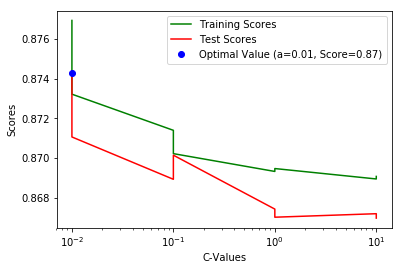


Confusion Matrix for Train Data :-
[[ 3925  3737]
 [  827 47511]]

TPR: 92.70800811738995 %
TNR: 82.59680134680136 %
FPR: 17.403198653198654 %
FNR: 7.291991882610054 %


Precision_Score of the Optimal LR classifier with parameters-{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'} is 87.16601695921628 %

Confusion Matrix for Test Data :-
[[ 2119  1980]
 [  417 19484]]

TPR: 90.77525158404771 %
TNR: 83.55678233438486 %
FPR: 16.443217665615144 %
FNR: 9.224748415952293 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.84      0.52      0.64      4099
          1       0.91      0.98      0.94     19901

avg / total       0.90      0.90      0.89     24000

Wall time: 39.9 s


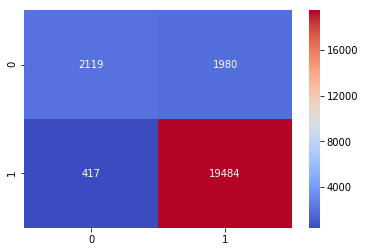

In [20]:
%%time
info = run_LR(data_train, sent_vectors_train, data_test, sent_vectors_test)

In [21]:
%%time
pt.add_row(['Avg. W2V'] + info[:-2])
print(pt)

+----------+-----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
|  Model   |                  Optimal Parameters                 |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  | FNR  |
+----------+-----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
|   BOW    |  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} | precision_macro | 90.02 | 94.48 | 85.57 | 14.43 | 5.52 |
|  TFIDF   |  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'} | precision_macro | 91.31 | 93.82 | 88.79 | 11.21 | 6.18 |
| Avg. W2V | {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'} | precision_macro | 87.17 | 90.78 | 83.56 | 16.44 | 9.22 |
+----------+-----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
Wall time: 2 ms


## TFIDF-weighted W2V Vectorizer based model

In [22]:
%%time
sent_vectors_train = pd.read_csv('./Matrices/tfidf_w2v_train.csv')
sent_vectors_test = pd.read_csv('./Matrices/tfidf_w2v_test.csv')

Wall time: 2.02 s


(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)


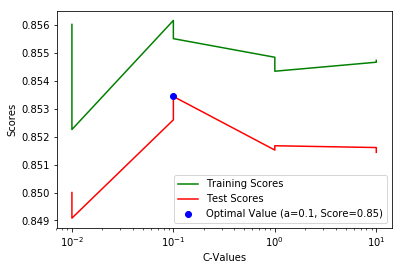


Confusion Matrix for Train Data :-
[[ 3892  3770]
 [ 1081 47257]]

TPR: 92.61175456131068 %
TNR: 78.26261813794491 %
FPR: 21.7373818620551 %
FNR: 7.388245438689321 %


Precision_Score of the Optimal LR classifier with parameters-{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} is 85.16403942772041 %

Confusion Matrix for Test Data :-
[[ 2068  2031]
 [  523 19378]]

TPR: 90.51333551310196 %
TNR: 79.81474334233887 %
FPR: 20.185256657661135 %
FNR: 9.486664486898032 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.80      0.50      0.62      4099
          1       0.91      0.97      0.94     19901

avg / total       0.89      0.89      0.88     24000

Wall time: 35.8 s


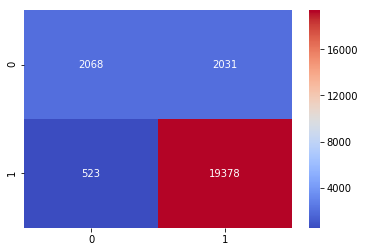

In [23]:
%%time
info = run_LR(data_train, sent_vectors_train, data_test, sent_vectors_test)

In [24]:
%%time
pt.add_row(['TFIDF W2V'] + info[:-2])
print(pt)

+-----------+-----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
|   Model   |                  Optimal Parameters                 |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  | FNR  |
+-----------+-----------------------------------------------------+-----------------+-------+-------+-------+-------+------+
|    BOW    |  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} | precision_macro | 90.02 | 94.48 | 85.57 | 14.43 | 5.52 |
|   TFIDF   |  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'} | precision_macro | 91.31 | 93.82 | 88.79 | 11.21 | 6.18 |
|  Avg. W2V | {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'} | precision_macro | 87.17 | 90.78 | 83.56 | 16.44 | 9.22 |
| TFIDF W2V |  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} | precision_macro | 85.16 | 90.51 | 79.81 | 20.19 | 9.49 |
+-----------+-----------------------------------------------------+-----------------+-------+-------+-------+-------+------+


# Conclusions :-
-  The Dataset being highly imbalanced (8:1) the Scoring metric has been selected based on the Model performance of - high TPR & TNR and low FPR & FNR.
-  Based on the above performance criteria, both 'recall' and 'precision_macro' have shown to provide high True Negative Rate (TNR) or low False Positive Rate (FPR). 'precision_macro' metric has been used here to evaluate the models. 
-  From the Performances obtained on the four Vectorizer models, it has been observed that TFIDF Vectorizer is giving the best performance - high TPR with the highest TNR.
-  The Model performance might improve if the unbalancedness of the dataset can be treated with Oversampling - repeating Minority class or creating Synthetic datapoints using SMOTE.
-  Reducing the 'n_components' in the Vectorizer models has proved to increase the True Negative Rate.